# Dataset Used:
[wikipedia-paragraphs](https://huggingface.co/datasets/agentlans/wikipedia-paragraphs) from Hugging Face


- What is the right way of clustering?
- Is it based on the closeness or cosine similarity? What happens when we have more similar words, how can we cluster them?
- Can we have a new clustering technique, based on the next token?


In [ ]:
pip install datasets

In [2]:
from datasets import load_dataset

ds = load_dataset("agentlans/wikipedia-paragraphs")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

train.jsonl.gz:   0%|          | 0.00/11.1M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
import numpy as np
import torch
from tqdm import tqdm

In [4]:
def load_paragraphs_hf():
    ds = load_dataset("agentlans/wikipedia-paragraphs", split="train")
    return ds["text"]

paragraphs = load_paragraphs_hf()
print(f"Loaded {len(paragraphs):,} paragraphs")

Loaded 21,811 paragraphs


In [5]:
print(paragraphs[0])

Perhaps the first public statement on the matter to be both serious and strong came from Catherine II (Catherine the Great), whose liberal views were consistent with her acceptance of the Enlightenment. In her Nakaz of 1767, the empress expressed disdain for the death penalty, considering it to be improper, adding: "In the usual state of the society, the death penalty is neither useful nor needed." However, an explicit exception was still allowed for the case of someone who, even while convicted and incarcerated, "still has the means and the might to ignite public unrest". This specific exception applied to mutineers of Pugachev's Rebellion in 1775. Consistent with Catherine's stance, the next several decades marked a shift in public perception against the death penalty. In 1824, the very existence of such a punishment was among the reasons for the legislature's refusal to approve a new version of the Penal Code. Just one year later, the Decembrist revolt failed, and a court sentenced 

### Clustering technique based on next token
- Extract random 4000 non-repeating unique tokens and cluster them based on next token

# Model: GPT-2

In [6]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
# initialize GPT-2
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained(
            "gpt2",
            output_hidden_states=True
         ).eval().cuda()


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

# Extract the Final Layer hidden state for the last token in each paragraph

- Extract the final layer in LLM which performs the softmax. (MLP or Fully connected NN)
- Now perform classification to predict the next word for a given input vector.
- Now count the number of these points inside each cluster and do the similar statistics. (Both old and New)



- extract the final-layer hidden state tensor: last_hidden [B, T, 768]
- extract the next token logits: logits [B, T, |V|].
- locate the last real token in every sequence using the attention-mask count (last_idx).


In [7]:
import torch.nn.functional as F
# make sure one record per unique current token ID
token_records = {}

BATCH = 16
for i in tqdm(range(0, len(paragraphs), BATCH), desc="Embedding"):
    batch = paragraphs[i:i+BATCH]
    inp = tokenizer(batch, return_tensors="pt",
                    padding=True, truncation=True, max_length=512).to("cuda")
    with torch.no_grad():
        out = model(**inp)

    last_hidden = out.hidden_states[-1]      # [B, T, 768]
    logits      = out.logits                 # [B, T, |V|]
    last_idx    = inp["attention_mask"].sum(dim=1) - 1

    for j, idx in enumerate(last_idx.tolist()):
        cur_token_id  = inp["input_ids"][j, idx].item()
        # if already have the token ID in token records
        if cur_token_id in token_records:
            continue

        vec           = last_hidden[j, idx, :].cpu().numpy()
        pred_next_id  = torch.argmax(logits[j, idx, :]).item()
        pred_prob     = F.softmax(logits[j, idx, :], dim=-1)[pred_next_id].item()
        token_records[cur_token_id] = (vec, pred_next_id, pred_prob, batch[j])

print(f"Unique current-token IDs seen: {len(token_records):,}")

Embedding: 100%|██████████| 1364/1364 [03:28<00:00,  6.55it/s]

Unique current-token IDs seen: 555


In [21]:
#tokens to keep
import random

TARGET_TOKENS = 555
all_ids = list(token_records.keys())

random.seed(42)
sampled_ids = random.sample(all_ids, TARGET_TOKENS)

print(f"Number of unique tokens as sample: {len(sampled_ids):,} (target = {TARGET_TOKENS:,})")


Number of unique tokens as sample: 555 (target = 555)


In [26]:
# Cluster by predicted next-token ID
from collections import defaultdict
clusters_by_next   = defaultdict(list)
paragraphs_by_next = defaultdict(list)

for tid in sampled_ids:
    vec, next_id, prob, para = token_records[tid]
    clusters_by_next[next_id].append(vec)
    paragraphs_by_next[next_id].append(para)

print(f"Number of clusters created (unique predicted-next IDs): {len(clusters_by_next)}")


Number of clusters created (unique predicted-next IDs): 203


In [27]:
sizes_and_ids = sorted(((len(v), nid) for nid, v in clusters_by_next.items()),
                       reverse=True)
freqs = np.array([s for s, _ in sizes_and_ids])


In [28]:
probs_list = [token_records[tid][2] for tid in sampled_ids]

print(f"\nPredicted-token probability stats "
      f"(sample of {len(sampled_ids)} tokens)")
print(f"  • max  : {max(probs_list):.4f}")
print(f"  • min  : {min(probs_list):.4f}")
print(f"  • mean : {np.mean(probs_list):.4f}")


Predicted-token probability stats (sample of 555 tokens)
  • max  : 0.9999
  • min  : 0.0072
  • mean : 0.3870


In [29]:
print("\nTop-40 predicted-next tokens by cluster size:\n"
      "Rank │ TokID │ Size │ Decoded token")
print("─────┼───────┼──────┼────────────────────────")
for rank, (size, nid) in enumerate(sizes_and_ids[:40], 1):
    tok_str = tokenizer.decode([nid]).replace("\n", "\\n")
    print(f"{rank:>4} │ {nid:>5} │ {size:>4} │ {tok_str!r}")



Top-40 predicted-next tokens by cluster size:
Rank │ TokID │ Size │ Decoded token
─────┼───────┼──────┼────────────────────────
   1 │    13 │  101 │ '.'
   2 │   383 │   46 │ ' The'
   3 │   198 │   38 │ '\\n'
   4 │    11 │   27 │ ','
   5 │   262 │   19 │ ' the'
   6 │   286 │   17 │ ' of'
   7 │    12 │   14 │ '-'
   8 │  1906 │   12 │ '–'
   9 │   290 │   10 │ ' and'
  10 │   366 │    9 │ ' "'
  11 │   284 │    9 │ ' to'
  12 │   287 │    7 │ ' in'
  13 │  1550 │    6 │ ' On'
  14 │   554 │    6 │ ' In'
  15 │ 10029 │    5 │ ' FC'
  16 │   532 │    5 │ ' -'
  17 │  8147 │    4 │ ' PA'
  18 │   357 │    4 │ ' ('
  19 │   326 │    4 │ ' that'
  20 │  5595 │    3 │ ' •'
  21 │  2901 │    3 │ ' July'
  22 │    25 │    3 │ ':'
  23 │     8 │    3 │ ')'
  24 │     1 │    3 │ '"'
  25 │ 31944 │    2 │ 'frac'
  26 │  3059 │    2 │ ' Sch'
  27 │  1058 │    2 │ ' :'
  28 │   767 │    2 │ ' 7'
  29 │   422 │    2 │ ' from'
  30 │   416 │    2 │ ' by'
  31 │   373 │    2 │ ' was'
  32 │   35

In [30]:
print("\nFirst five paragraphs in each of the TOP-3 predicted tokens:\n")
for rank, (size, nid) in enumerate(sizes_and_ids[:3], 1):
    tok_str = tokenizer.decode([nid]).replace("\n", "\\n")
    print(f"▶ Rank {rank} – token {nid} {tok_str!r} (cluster size {size})")
    for i, para in enumerate(paragraphs_by_next[nid][:5], 1):
        short = para.strip().replace("\n", " ")[:180] + "…"
        print(f"   {i}. {short}")
    print()



First five paragraphs in each of the TOP-3 predicted tokens:

▶ Rank 1 – token 13 '.' (cluster size 101)
   1. "Recorded just hours before an airplane crash would take her life, 1969: Siempre: En Vivo Desde Monterrey, Pt.1 captures Jenni Rivera's last concert, a show in Monterrey, Mexico on…
   2. Hardcore and metalcore are most common in Budapest and Western Hungary, in towns like Győr, Csorna, Szombathely and Veszprém, but Eastern Hungary and Debrecen is getting into a mor…
   3. My Lords, it has been held at first instance and in the Court of Appeal that Blake is not a fiduciary. This is not an issue before the House. But, as my noble and learned friend Lo…
   4. On 27 August at 01:35 a U.S. Navy PBR and a patrol from the 1st Brigade, 1st Infantry Division ambushed a 15-20 man PAVN/VC unit attempting to cross the Saigon River 8 miles (13 km…
   5. On 9 May 1966 Colonel Cecil F. Hunnicutt became senior adviser to the 25th Division. His immediate superior, Colonel Arndt Mueller, the 

# Plots


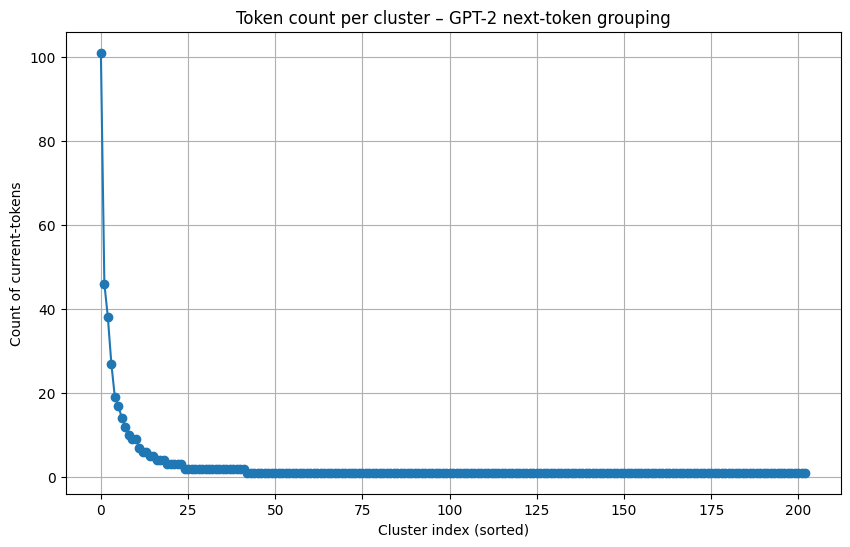

In [32]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

plt.figure(figsize=(10, 6))
plt.plot(range(len(freqs)), freqs, marker='o')
plt.title("Token count per cluster – GPT-2 next-token grouping")
plt.xlabel("Cluster index (sorted)")
plt.ylabel("Count of current-tokens")
plt.grid(True)
plt.show()

In [33]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

ranks = np.arange(1, len(freqs)+1)
log_r, log_f = np.log10(ranks), np.log10(freqs)
slope, intercept, r_val, p_val, _ = linregress(log_r, log_f)
y_pred = slope * log_r + intercept

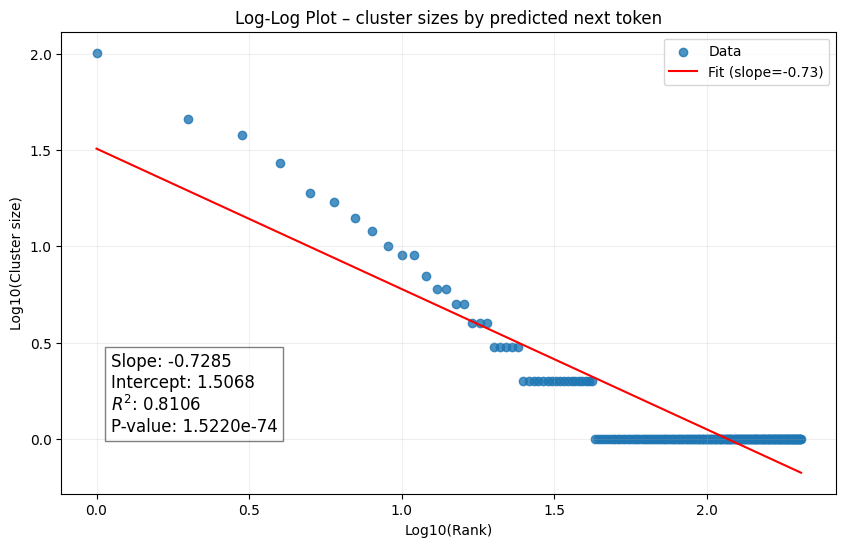


Regression Results:
   - Slope: -0.7285
   - Intercept: 1.5068
   - R-squared: 0.8106
   - P-value: 1.5220e-74


In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(log_r, log_f, alpha=0.8, label="Data")
plt.plot(log_r, y_pred, 'r-', label=f'Fit (slope={slope:.2f})')
plt.title("Log-Log Plot – cluster sizes by predicted next token")
plt.xlabel("Log10(Rank)")
plt.ylabel("Log10(Cluster size)")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()

# annotate regression stats
txt_x = log_r.min() + (log_r.max() - log_r.min())*0.02
txt_y = log_f.min() + (log_f.max() - log_f.min())*0.02
plt.text(txt_x, txt_y,
         f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\n"
         f"$R^2$: {r_val**2:.4f}\nP-value: {p_val:.4e}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

print("\nRegression Results:")
print(f"   - Slope: {slope:.4f}")
print(f"   - Intercept: {intercept:.4f}")
print(f"   - R-squared: {r_val**2:.4f}")
print(f"   - P-value: {p_val:.4e}")
